# Hat graph

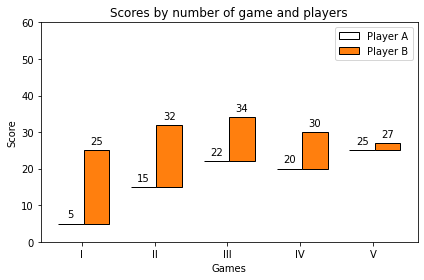

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def hat_graph(ax, xlabels, values, group_labels):
    """
    Create a hat graph.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The Axes to plot into.
    xlabels : list of str
        The category names to be displayed on the x-axis.
    values : (M, N) array-like
        The data values.
        Rows are the groups (len(group_labels) == M).
        Columns are the categories (len(xlabels) == N).
    group_labels : list of str
        The group labels displayed in the legend.
    """

    def label_bars(heights, rects):
        """Attach a text label on top of each bar."""
        for height, rect in zip(heights, rects):
            ax.annotate(f'{height}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 4),  # 4 points vertical offset.
                        textcoords='offset points',
                        ha='center', va='bottom')

    values = np.asarray(values)
    x = np.arange(values.shape[1])
    ax.set_xticks(x, labels=xlabels)
    spacing = 0.3  # spacing between hat groups
    width = (1 - spacing) / values.shape[0]
    heights0 = values[0]
    for i, (heights, group_label) in enumerate(zip(values, group_labels)):
        style = {'fill': False} if i == 0 else {'edgecolor': 'black'}
        rects = ax.bar(x - spacing/2 + i * width, heights - heights0,
                       width, bottom=heights0, label=group_label, **style)
        label_bars(heights, rects)


xlabels = ['I', 'II', 'III', 'IV', 'V']
playerA = np.array([5, 15, 22, 20, 25])
playerB = np.array([25, 32, 34, 30, 27])

fig, ax = plt.subplots()
hat_graph(ax, xlabels, [playerA, playerB], ['Player A', 'Player B'])

ax.set_xlabel('Games')
ax.set_ylabel('Score')
ax.set_ylim(0, 60)
ax.set_title('Scores by number of game and players')
ax.legend()

fig.tight_layout()
plt.show()

# Scale invariant angle label

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from matplotlib.transforms import IdentityTransform, TransformedBbox, Bbox


class AngleAnnotation(Arc):
    """
    Draws an arc between two vectors which appears circular in display space.
    """
    def __init__(self, xy, p1, p2, size=75, unit="points", ax=None,
                 text="", textposition="inside", text_kw=None, **kwargs):
        """
        Parameters
        ----------
        xy, p1, p2 : tuple or array of two floats
            Center position and two points. Angle annotation is drawn between
            the two vectors connecting *p1* and *p2* with *xy*, respectively.
            Units are data coordinates.

        size : float
            Diameter of the angle annotation in units specified by *unit*.

        unit : str
            One of the following strings to specify the unit of *size*:

            * "pixels": pixels
            * "points": points, use points instead of pixels to not have a
              dependence on the DPI
            * "axes width", "axes height": relative units of Axes width, height
            * "axes min", "axes max": minimum or maximum of relative Axes
              width, height

        ax : `matplotlib.axes.Axes`
            The Axes to add the angle annotation to.

        text : str
            The text to mark the angle with.

        textposition : {"inside", "outside", "edge"}
            Whether to show the text in- or outside the arc. "edge" can be used
            for custom positions anchored at the arc's edge.

        text_kw : dict
            Dictionary of arguments passed to the Annotation.

        **kwargs
            Further parameters are passed to `matplotlib.patches.Arc`. Use this
            to specify, color, linewidth etc. of the arc.

        """
        self.ax = ax or plt.gca()
        self._xydata = xy  # in data coordinates
        self.vec1 = p1
        self.vec2 = p2
        self.size = size
        self.unit = unit
        self.textposition = textposition

        super().__init__(self._xydata, size, size, angle=0.0,
                         theta1=self.theta1, theta2=self.theta2, **kwargs)

        self.set_transform(IdentityTransform())
        self.ax.add_patch(self)

        self.kw = dict(ha="center", va="center",
                       xycoords=IdentityTransform(),
                       xytext=(0, 0), textcoords="offset points",
                       annotation_clip=True)
        self.kw.update(text_kw or {})
        self.text = ax.annotate(text, xy=self._center, **self.kw)

    def get_size(self):
        factor = 1.
        if self.unit == "points":
            factor = self.ax.figure.dpi / 72.
        elif self.unit[:4] == "axes":
            b = TransformedBbox(Bbox.unit(), self.ax.transAxes)
            dic = {"max": max(b.width, b.height),
                   "min": min(b.width, b.height),
                   "width": b.width, "height": b.height}
            factor = dic[self.unit[5:]]
        return self.size * factor

    def set_size(self, size):
        self.size = size

    def get_center_in_pixels(self):
        """return center in pixels"""
        return self.ax.transData.transform(self._xydata)

    def set_center(self, xy):
        """set center in data coordinates"""
        self._xydata = xy

    def get_theta(self, vec):
        vec_in_pixels = self.ax.transData.transform(vec) - self._center
        return np.rad2deg(np.arctan2(vec_in_pixels[1], vec_in_pixels[0]))

    def get_theta1(self):
        return self.get_theta(self.vec1)

    def get_theta2(self):
        return self.get_theta(self.vec2)

    def set_theta(self, angle):
        pass

    # Redefine attributes of the Arc to always give values in pixel space
    _center = property(get_center_in_pixels, set_center)
    theta1 = property(get_theta1, set_theta)
    theta2 = property(get_theta2, set_theta)
    width = property(get_size, set_size)
    height = property(get_size, set_size)

    # The following two methods are needed to update the text position.
    def draw(self, renderer):
        self.update_text()
        super().draw(renderer)

    def update_text(self):
        c = self._center
        s = self.get_size()
        angle_span = (self.theta2 - self.theta1) % 360
        angle = np.deg2rad(self.theta1 + angle_span / 2)
        r = s / 2
        if self.textposition == "inside":
            r = s / np.interp(angle_span, [60, 90, 135, 180],
                                          [3.3, 3.5, 3.8, 4])
        self.text.xy = c + r * np.array([np.cos(angle), np.sin(angle)])
        if self.textposition == "outside":
            def R90(a, r, w, h):
                if a < np.arctan(h/2/(r+w/2)):
                    return np.sqrt((r+w/2)**2 + (np.tan(a)*(r+w/2))**2)
                else:
                    c = np.sqrt((w/2)**2+(h/2)**2)
                    T = np.arcsin(c * np.cos(np.pi/2 - a + np.arcsin(h/2/c))/r)
                    xy = r * np.array([np.cos(a + T), np.sin(a + T)])
                    xy += np.array([w/2, h/2])
                    return np.sqrt(np.sum(xy**2))

            def R(a, r, w, h):
                aa = (a % (np.pi/4))*((a % (np.pi/2)) <= np.pi/4) + \
                     (np.pi/4 - (a % (np.pi/4)))*((a % (np.pi/2)) >= np.pi/4)
                return R90(aa, r, *[w, h][::int(np.sign(np.cos(2*a)))])

            bbox = self.text.get_window_extent()
            X = R(angle, r, bbox.width, bbox.height)
            trans = self.ax.figure.dpi_scale_trans.inverted()
            offs = trans.transform(((X-s/2), 0))[0] * 72
            self.text.set_position([offs*np.cos(angle), offs*np.sin(angle)])

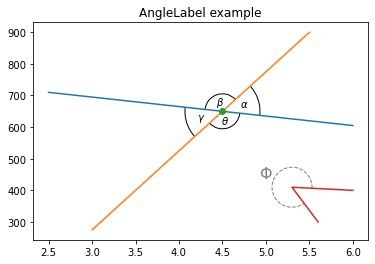

In [3]:
fig, ax = plt.subplots()
fig.canvas.draw()  # Need to draw the figure to define renderer
ax.set_title("AngleLabel example")

# Plot two crossing lines and label each angle between them with the above
# ``AngleAnnotation`` tool.
center = (4.5, 650)
p1 = [(2.5, 710), (6.0, 605)]
p2 = [(3.0, 275), (5.5, 900)]
line1, = ax.plot(*zip(*p1))
line2, = ax.plot(*zip(*p2))
point, = ax.plot(*center, marker="o")

am1 = AngleAnnotation(center, p1[1], p2[1], ax=ax, size=75, text=r"$\alpha$")
am2 = AngleAnnotation(center, p2[1], p1[0], ax=ax, size=35, text=r"$\beta$")
am3 = AngleAnnotation(center, p1[0], p2[0], ax=ax, size=75, text=r"$\gamma$")
am4 = AngleAnnotation(center, p2[0], p1[1], ax=ax, size=35, text=r"$\theta$")


# Showcase some styling options for the angle arc, as well as the text.
p = [(6.0, 400), (5.3, 410), (5.6, 300)]
ax.plot(*zip(*p))
am5 = AngleAnnotation(p[1], p[0], p[2], ax=ax, size=40, text=r"$\Phi$",
                      linestyle="--", color="gray", textposition="outside",
                      text_kw=dict(fontsize=16, color="gray"))

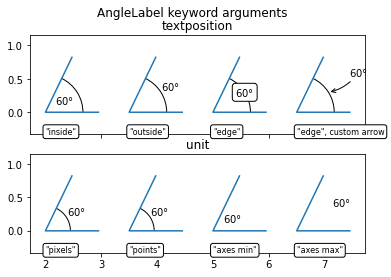

In [4]:
# Helper function to draw angle easily.
def plot_angle(ax, pos, angle, length=0.95, acol="C0", **kwargs):
    vec2 = np.array([np.cos(np.deg2rad(angle)), np.sin(np.deg2rad(angle))])
    xy = np.c_[[length, 0], [0, 0], vec2*length].T + np.array(pos)
    ax.plot(*xy.T, color=acol)
    return AngleAnnotation(pos, xy[0], xy[2], ax=ax, **kwargs)


fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
fig.suptitle("AngleLabel keyword arguments")
fig.canvas.draw()  # Need to draw the figure to define renderer

# Showcase different text positions.
ax1.margins(y=0.4)
ax1.set_title("textposition")
kw = dict(size=75, unit="points", text=r"$60°$")

am6 = plot_angle(ax1, (2.0, 0), 60, textposition="inside", **kw)
am7 = plot_angle(ax1, (3.5, 0), 60, textposition="outside", **kw)
am8 = plot_angle(ax1, (5.0, 0), 60, textposition="edge",
                 text_kw=dict(bbox=dict(boxstyle="round", fc="w")), **kw)
am9 = plot_angle(ax1, (6.5, 0), 60, textposition="edge",
                 text_kw=dict(xytext=(30, 20), arrowprops=dict(arrowstyle="->",
                              connectionstyle="arc3,rad=-0.2")), **kw)

for x, text in zip([2.0, 3.5, 5.0, 6.5], ['"inside"', '"outside"', '"edge"',
                                          '"edge", custom arrow']):
    ax1.annotate(text, xy=(x, 0), xycoords=ax1.get_xaxis_transform(),
                 bbox=dict(boxstyle="round", fc="w"), ha="left", fontsize=8,
                 annotation_clip=True)

# Showcase different size units. The effect of this can best be observed
# by interactively changing the figure size
ax2.margins(y=0.4)
ax2.set_title("unit")
kw = dict(text=r"$60°$", textposition="outside")

am10 = plot_angle(ax2, (2.0, 0), 60, size=50, unit="pixels", **kw)
am11 = plot_angle(ax2, (3.5, 0), 60, size=50, unit="points", **kw)
am12 = plot_angle(ax2, (5.0, 0), 60, size=0.25, unit="axes min", **kw)
am13 = plot_angle(ax2, (6.5, 0), 60, size=0.25, unit="axes max", **kw)

for x, text in zip([2.0, 3.5, 5.0, 6.5], ['"pixels"', '"points"',
                                          '"axes min"', '"axes max"']):
    ax2.annotate(text, xy=(x, 0), xycoords=ax2.get_xaxis_transform(),
                 bbox=dict(boxstyle="round", fc="w"), ha="left", fontsize=8,
                 annotation_clip=True)

plt.show()

# Annotate Transform


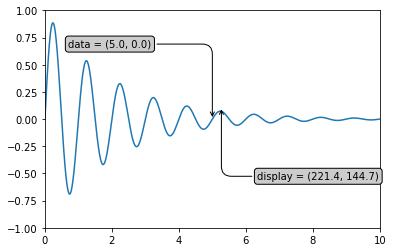

In [5]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0, 10, 0.005)
y = np.exp(-x/2.) * np.sin(2*np.pi*x)

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlim(0, 10)
ax.set_ylim(-1, 1)

xdata, ydata = 5, 0
xdisplay, ydisplay = ax.transData.transform((xdata, ydata))

bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=90,rad=10")

offset = 72
ax.annotate(
    f'data = ({xdata:.1f}, {ydata:.1f})',
    (xdata, ydata),
    xytext=(-2*offset, offset), textcoords='offset points',
    bbox=bbox, arrowprops=arrowprops)
ax.annotate(
    f'display = ({xdisplay:.1f}, {ydisplay:.1f})',
    xy=(xdisplay, ydisplay), xycoords='figure pixels',
    xytext=(0.5*offset, -offset), textcoords='offset points',
    bbox=bbox, arrowprops=arrowprops)

plt.show()

# Annotating a plot

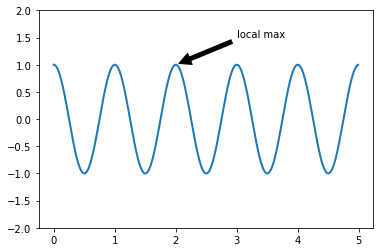

In [6]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

t = np.arange(0.0, 5.0, 0.01)
s = np.cos(2*np.pi*t)
line, = ax.plot(t, s, lw=2)

ax.annotate('local max', xy=(2, 1), xytext=(3, 1.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax.set_ylim(-2, 2)
plt.show()

# Annotation Polar


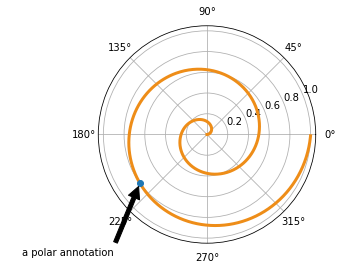

In [7]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='polar')
r = np.arange(0, 1, 0.001)
theta = 2 * 2*np.pi * r
line, = ax.plot(theta, r, color='#ee8d18', lw=3)

ind = 800
thisr, thistheta = r[ind], theta[ind]
ax.plot([thistheta], [thisr], 'o')
ax.annotate('a polar annotation',
            xy=(thistheta, thisr),  # theta, radius
            xytext=(0.05, 0.05),    # fraction, fraction
            textcoords='figure fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left',
            verticalalignment='bottom',
            )
plt.show()

# Pyplot tutorial

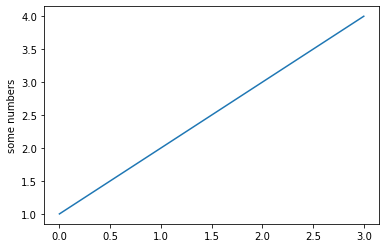

In [8]:
import matplotlib.pyplot as plt
plt.plot([1, 2, 3, 4])
plt.ylabel('some numbers')
plt.show()

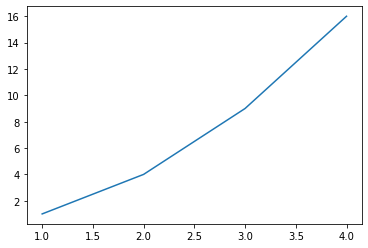

In [9]:
plt.plot([1, 2, 3, 4], [1, 4, 9, 16])

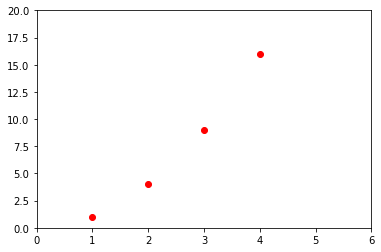

In [10]:
plt.plot([1, 2, 3, 4], [1, 4, 9, 16], 'ro')
plt.axis([0, 6, 0, 20])
plt.show()

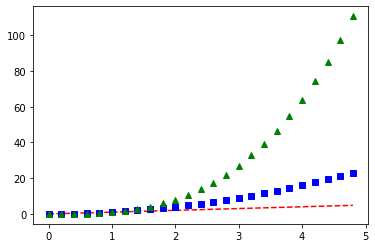

In [11]:
import numpy as np

# evenly sampled time at 200ms intervals
t = np.arange(0., 5., 0.2)

# red dashes, blue squares and green triangles
plt.plot(t, t, 'r--', t, t**2, 'bs', t, t**3, 'g^')
plt.show()

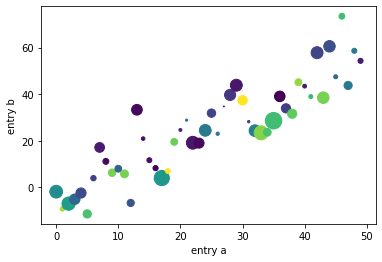

In [12]:
data = {'a': np.arange(50),
        'c': np.random.randint(0, 50, 50),
        'd': np.random.randn(50)}
data['b'] = data['a'] + 10 * np.random.randn(50)
data['d'] = np.abs(data['d']) * 100

plt.scatter('a', 'b', c='c', s='d', data=data)
plt.xlabel('entry a')
plt.ylabel('entry b')
plt.show()

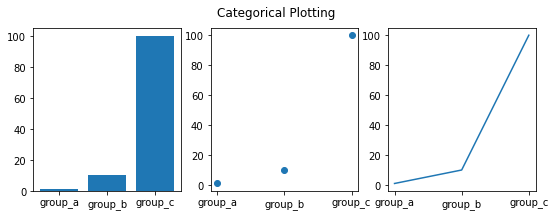

In [13]:
names = ['group_a', 'group_b', 'group_c']
values = [1, 10, 100]

plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.bar(names, values)
plt.subplot(132)
plt.scatter(names, values)
plt.subplot(133)
plt.plot(names, values)
plt.suptitle('Categorical Plotting')
plt.show()